### Calculation of the correlation matrix for all the estimators

In [19]:
from RogerSatchell import rogers_satchell_volatility
from Parkinson import Parkinson
from GarmanKlass import garman_klass__estimator
import YangZhang as yz 
from Closetoclose import close_to_close
import numpy as np
import pandas as pd
import yfinance as yf

data = yf.download('SPY', start='2000-01-01', end='2014-01-01')

k = 1 

#preparation of the data for each estimator
A = pd.Series(close_to_close(data)[1:])
B = pd.Series(garman_klass__estimator(data))
C = pd.Series(Parkinson(data))
D = pd.Series(rogers_satchell_volatility(data)[1:])
E = pd.Series(yz.calculate_yang_zhang(data, k)[1:])

estimators = [A, B, C, D, E]

# calculation of the correlation matrix
correlation_matrix = np.zeros((5, 5))
for i in range(len(estimators)):
    for j in range(len(estimators)):
        correlation_matrix[i, j] = estimators[i].corr(estimators[j])

#display of the correlations
labels = ['Close to Close', 'Garman Klass', 'Parkinson', 'Roger Satchell', 'Yang Zhang']
df_correlation = pd.DataFrame(correlation_matrix, index=labels, columns=labels)

print(df_correlation)


[*********************100%%**********************]  1 of 1 completed

                Close to Close  Garman Klass  Parkinson  Roger Satchell  \
Close to Close        1.000000      0.621091   0.731183        0.522487   
Garman Klass          0.621091      1.000000   0.967018        0.979675   
Parkinson             0.731183      0.967018   1.000000        0.902979   
Roger Satchell        0.522487      0.979675   0.902979        1.000000   
Yang Zhang            0.848369      0.695364   0.828181        0.576099   

                Yang Zhang  
Close to Close    0.848369  
Garman Klass      0.695364  
Parkinson         0.828181  
Roger Satchell    0.576099  
Yang Zhang        1.000000  


### Calculation of the correlation between the estimators and the true volatility

In [20]:
import warnings
warnings.filterwarnings("ignore")

#filtering of the data to erase all the "NaN" types (showing "nan"), working more effectively than the regular .dropna()
data_frame = pd.read_csv("RealizedVarianceData.csv")
a=pd.read_csv("RealizedVarianceData.csv",skiprows=[0])
d=a["SPX2.rv"].tolist()
for k in range(len(d)):
    if str(d[k])=="nan":
        d[k]=d[k-1]

true_volatility = pd.Series(d)
true_volatility = true_volatility.dropna()
estimators = [pd.Series(estimator) for estimator in estimators] 

#calculation of the correlations with the true data
correlation_with_true_vol = np.zeros(5)
for i in range(len(correlation_with_true_vol)):
    if not any(pd.isna(true_volatility)) and not any(pd.isna(estimators[i])):   #to avoid all warnings and errors
        d=estimators[i].tolist()
        for k in range(len(d)):
            if str(d[k])=="nan":
                 d[k]=d[k-1]
        correlation_with_true_vol[i] = pd.Series(d).corr(true_volatility)

df_corr_true_vol = pd.DataFrame([correlation_with_true_vol], columns=labels)
print("Correlation with True Volatility:\n", df_corr_true_vol)

Correlation with True Volatility:
    Close to Close  Garman Klass  Parkinson  Roger Satchell  Yang Zhang
0        0.144504      0.234906   0.230696        0.212936    0.168274


### Plot of the MSE for each estimator of the volatility

[*********************100%%**********************]  1 of 1 completed


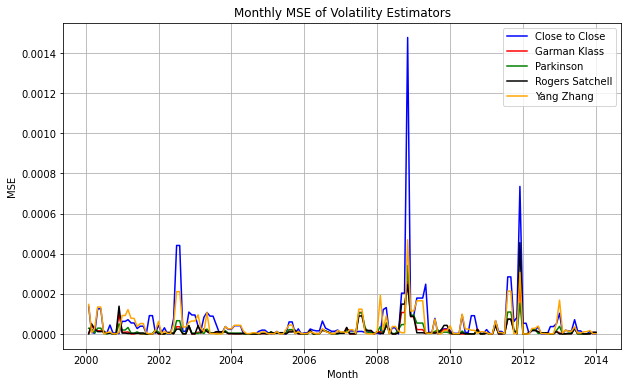

In [34]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

#preparation of the data
data['Date'] = data.index
data['Month'] = data['Date'].dt.to_period('M')
data = yf.download('SPY', start='2000-01-01', end='2014-01-01')
data.index = pd.to_datetime(data.index)
true_volatility = d

data['Estimator1'] = close_to_close(data)
data['Estimator2'] = garman_klass__estimator(data)  
data['Estimator3'] = Parkinson(data)     
data['Estimator4'] = rogers_satchell_volatility(data)
data['Estimator5'] = yz.calculate_yang_zhang(data, k=1)  


data['True_Volatility'] = [0]+true_volatility
monthly_true_volatility = data['True_Volatility'].resample('M').mean()

#calculation of all the MSE for each estimator on a monthly basis
def calculate_monthly_mse(estimator, true_volatility):
    return ((estimator - true_volatility) ** 2).resample('M').mean()

monthly_mse = pd.DataFrame({
    'Estimator1': calculate_monthly_mse(data['Estimator1'], monthly_true_volatility),
    'Estimator2': calculate_monthly_mse(data['Estimator2'], monthly_true_volatility),
    'Estimator3': calculate_monthly_mse(data['Estimator3'], monthly_true_volatility),
    'Estimator4': calculate_monthly_mse(data['Estimator4'], monthly_true_volatility),
    'Estimator5': calculate_monthly_mse(data['Estimator5'], monthly_true_volatility)
})

plt.figure(figsize=(10, 6))
plt.plot(monthly_mse.index.tolist(), monthly_mse['Estimator1'].fillna(method='bfill').tolist(), label='Close to Close', color='blue')
plt.plot(monthly_mse.index.tolist(), monthly_mse['Estimator2'].fillna(method='bfill').tolist(), label='Garman Klass', color='red')
plt.plot(monthly_mse.index.tolist(), monthly_mse['Estimator3'].fillna(method='bfill').tolist(), label='Parkinson', color='green')
plt.plot(monthly_mse.index.tolist(), monthly_mse['Estimator4'].fillna(method='bfill').tolist(), label='Rogers Satchell', color='black')
plt.plot(monthly_mse.index.tolist(), monthly_mse['Estimator5'].fillna(method='bfill').tolist(), label='Yang Zhang', color='orange')

plt.title('Monthly MSE of Volatility Estimators')
plt.xlabel('Month')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

### Plots of the distribution of the MSE for each estimator

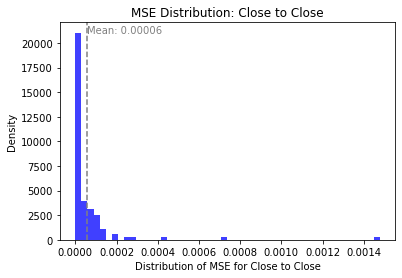

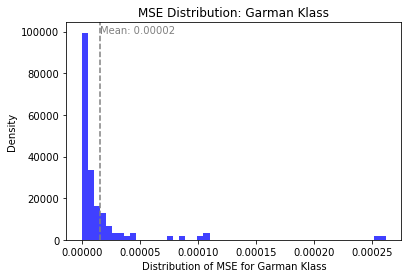

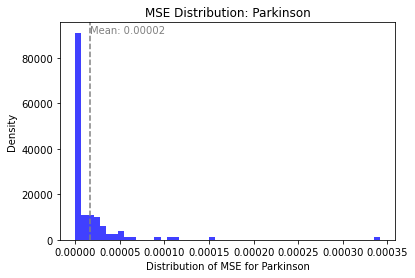

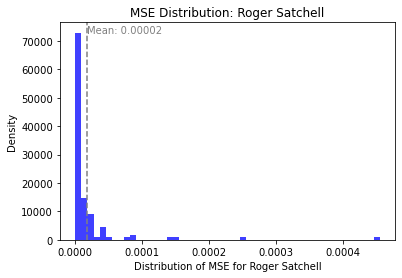

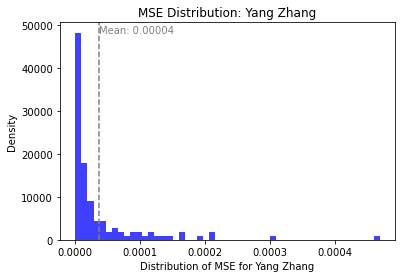

Estimators sorted from least to most biased based on MSE:
Garman Klass: 1.570978839865738e-05
Parkinson: 1.674413969173258e-05
Roger Satchell: 1.823170837408696e-05
Yang Zhang: 3.698073708260592e-05
Close to Close: 5.881714504740138e-05


In [40]:
import matplotlib.pyplot as plt

legends = ['Close to Close', 'Garman Klass', 'Parkinson', 'Roger Satchell', 'Yang Zhang']

mse_means = {}  

for i in range(1, 6):
    x = f'Estimator{i}'
    liste = monthly_mse[x].tolist() #calculation of each MSE on a monthly basis

    mean_mse = np.nanmean(liste)
    mse_means[legends[i-1]] = mean_mse  # Store each mean in a dictionnary for later comparison 

    density, bins, _ = plt.hist(liste, bins=50, alpha=0.75, color='blue', density=True)
    plt.xlabel(f'Distribution of MSE for {legends[i-1]}')
    plt.ylabel('Density')
    plt.axvline(x=mean_mse, color='gray', linestyle='--')
    plt.text(mean_mse, plt.ylim()[1] * 0.95, f'Mean: {mean_mse:.5f}', color='gray', ha='left')
    plt.title(f'MSE Distribution: {legends[i-1]}')
    plt.show()

sorted_means = sorted(mse_means.items(), key=lambda item: item[1])  #comparison of the estimators based on their MSE means over the whole period
print("Estimators sorted from least to most biased based on MSE:")
for estimator, mse in sorted_means:
    print(f"{estimator}: {mse}")



### Plots of the distribution of the bias for each estimator

In [25]:

#preparation of the data for the calculation of the bias for each month and estimator

monthly_true_volatility = data['True_Volatility'].resample('M').mean()
data['True_Volatility'] = data['Close'].pct_change().rolling(window=30).std()

def calculate_monthly_mean(estimateur):
    return estimateur.resample('M').mean()

def calculate_monthly_bias(estimator, true_volatility):
    return (true_volatility-calculate_monthly_mean(estimator))

monthly_bias = pd.DataFrame({
    'Estimator1': calculate_monthly_bias(data['Estimator1'], data['True_Volatility']),
    'Estimator2': calculate_monthly_bias(data['Estimator2'], data['True_Volatility']),
    'Estimator3': calculate_monthly_bias(data['Estimator3'], data['True_Volatility']),
    'Estimator4': calculate_monthly_bias(data['Estimator4'], data['True_Volatility']),
    'Estimator5': calculate_monthly_bias(data['Estimator5'], data['True_Volatility'])
})

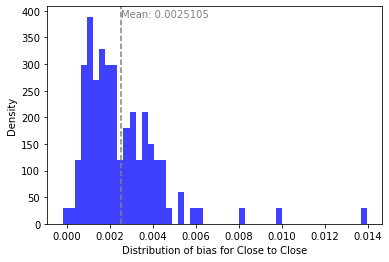

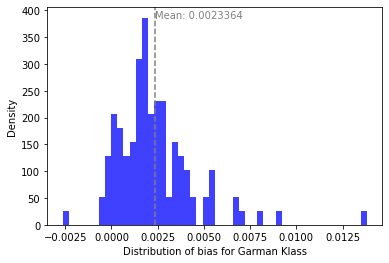

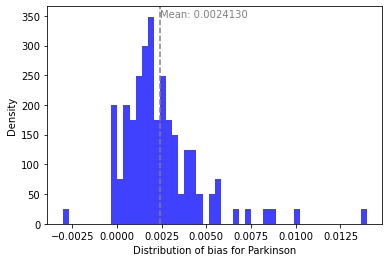

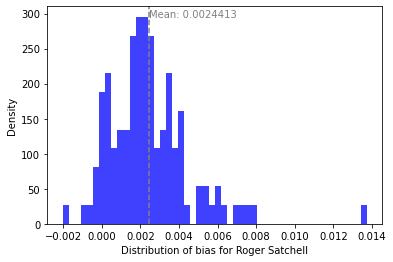

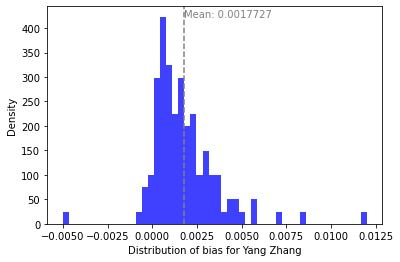

Estimators sorted from least to most biased based on MSE:
Yang Zhang: 0.0017727063642614875
Garman Klass: 0.0023364272188480272
Parkinson: 0.0024130028791542945
Roger Satchell: 0.002441267428890797
Close to Close: 0.0025104950959297426


In [41]:
import matplotlib.pyplot as plt

bias_means = {}

for i in range (1,6):

    x = f'Estimator{i}'
    liste = monthly_bias[x].tolist()
    bias_means[legends[i-1]] = np.nanmean(liste)

    density, bins, _ = plt.hist(liste, bins=50, alpha=0.75, color='blue', density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    plt.xlabel(f'Distribution of bias for {legends[i-1]}')
    plt.ylabel('Density')
    plt.axvline(x=np.nanmean(liste),color='gray',linestyle='--')
    plt.text(np.nanmean(liste), plt.ylim()[1] * 0.95, f'Mean: {np.nanmean(liste):.7f}', color='gray', ha='left')
    plt.show()

#same sorting than for the MSE, for comparison
sorted_estimators = sorted(bias_means.items(), key=lambda item: item[1])

print("Estimators sorted from least to most biased based on MSE:")
for estimator, bias in sorted_estimators:
    print(f"{estimator}: {bias}")

### Plot of the distribution of the ratios of variances for every combination of estimators

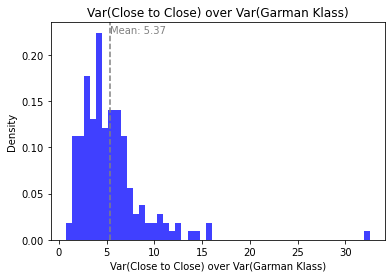

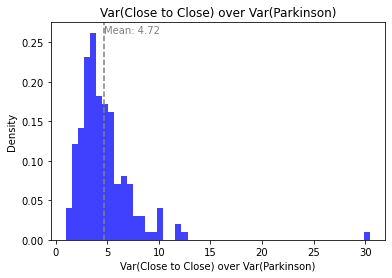

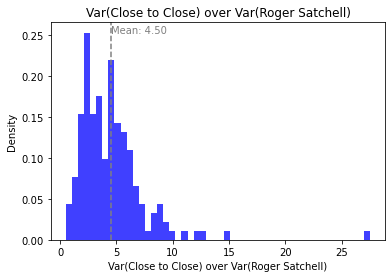

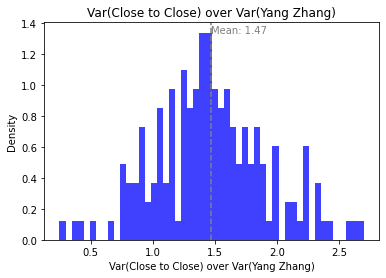

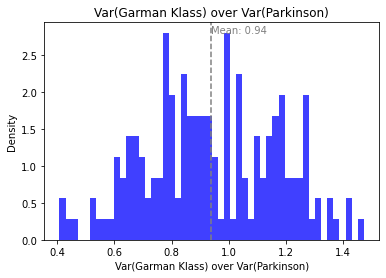

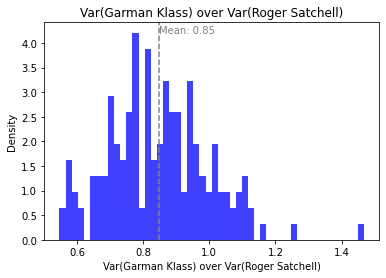

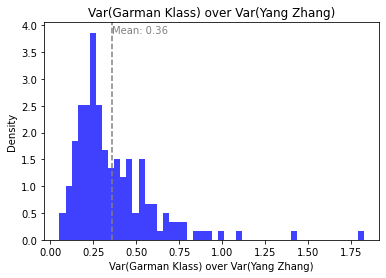

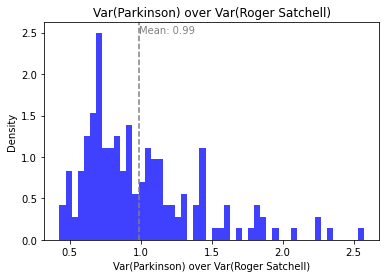

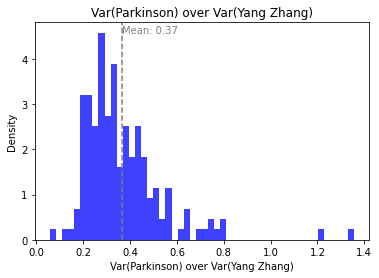

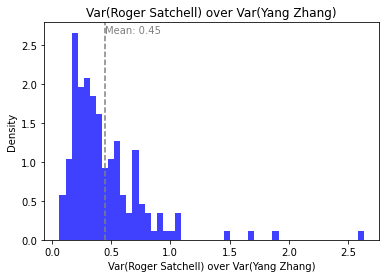

Var(Garman Klass) over Var(Yang Zhang): 0.36
Var(Parkinson) over Var(Yang Zhang): 0.37
Var(Roger Satchell) over Var(Yang Zhang): 0.45
Var(Garman Klass) over Var(Roger Satchell): 0.85
Var(Garman Klass) over Var(Parkinson): 0.94
Var(Parkinson) over Var(Roger Satchell): 0.99
Var(Close to Close) over Var(Yang Zhang): 1.47
Var(Close to Close) over Var(Roger Satchell): 4.50
Var(Close to Close) over Var(Parkinson): 4.72
Var(Close to Close) over Var(Garman Klass): 5.37


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def calculate_monthly_var(estimator):
    return estimator.resample('M').var()

monthly_var = pd.DataFrame({
    'Estimator1': calculate_monthly_var(data['Estimator1']),
    'Estimator2': calculate_monthly_var(data['Estimator2']),
    'Estimator3': calculate_monthly_var(data['Estimator3']),
    'Estimator4': calculate_monthly_var(data['Estimator4']),
    'Estimator5': calculate_monthly_var(data['Estimator5'])
})

div = lambda l1, l2: [l1[k]/l2[k] for k in range(len(l1))]

variance_ratios_means = {}

for i in range(1, 6):   #each combination of two distinct estimators is tested
    for j in range(i+1, 6):
        x = f'Estimator{i}'
        y = f'Estimator{j}'
        liste_x = monthly_var[x].tolist()
        liste_y = monthly_var[y].tolist()
        ratio_list = div(liste_x, liste_y)  #list for all ratios of variances

        mean_ratio = np.nanmean(ratio_list)
        key_name = f'Var({legends[i-1]}) over Var({legends[j-1]})'
        variance_ratios_means[key_name] = mean_ratio
        
        density, bins, _ = plt.hist(ratio_list, bins=50, alpha=0.75, color='blue', density=True)
        plt.xlabel(key_name)
        plt.ylabel('Density')
        plt.axvline(x=mean_ratio, color='gray', linestyle='--')
        plt.text(mean_ratio, plt.ylim()[1] * 0.95, f'Mean: {mean_ratio:.2f}', color='gray', ha='left')
        plt.title(key_name)
        plt.show()

sorted_means = sorted(variance_ratios_means.items(), key=lambda item: item[1])
for name, mean in sorted_means:
    print(f"{name}: {mean:.2f}")



### Plots of the distribution of the variance for each estimator

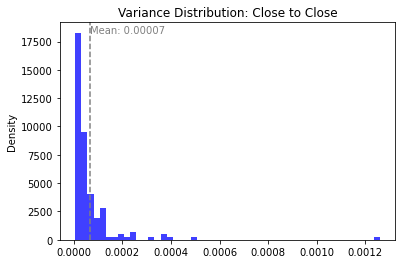

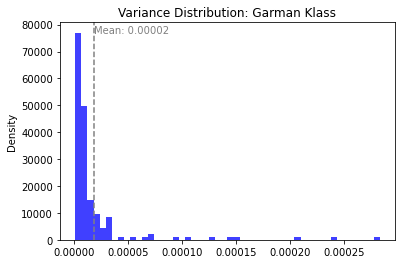

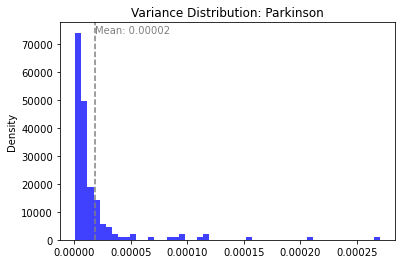

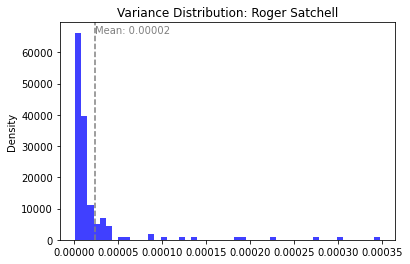

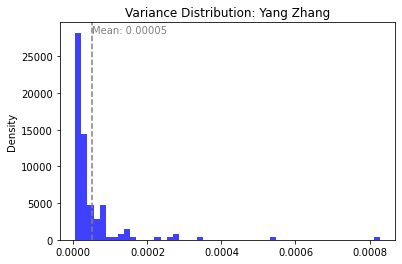

Parkinson: 0.0000182
Garman Klass: 0.0000183
Roger Satchell: 0.0000230
Yang Zhang: 0.0000489
Close to Close: 0.0000671


In [43]:
import numpy as np
import matplotlib.pyplot as plt

#same procedure than the cell above

var_means = {}  

for i in range(1, 6):
    x = f'Estimator{i}'
    liste = monthly_var[x].tolist()

    mean_var = np.mean(liste)
    var_means[legends[i-1]] = mean_var  
    density, bins, _ = plt.hist(liste, bins=50, alpha=0.75, color='blue', density=True)
    plt.ylabel('Density')
    plt.axvline(x=mean_var, color='gray', linestyle='--')
    plt.text(mean_var, plt.ylim()[1] * 0.95, f'Mean: {mean_var:.5f}', color='gray', ha='left')
    plt.title(f'Variance Distribution: {legends[i-1]}')
    plt.show()

sorted_means = sorted(var_means.items(), key=lambda item: item[1])
for estimator, variance in sorted_means:
    print(f"{estimator}: {variance:.7f}")
